In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

### Histórico de navegação
Podemos usar `get_state` para verificar o estado atual do nosso grafo, dado o thread_id

In [ ]:
graph.get_state({"configurable": {"thread_id": "1"}})

Também podemos consultar o histórico de estado do nosso agente.

O comando `get_state_history` permite obter o estado em todas as etapas anteriores.

In [ ]:
all_states= [s for s in graph.get_state_history(thread)]

In [ ]:
len(all_states)

O primeiro elemento é o estado atual, exatamente como obtivemos de `get_state`.

In [ ]:
all_states[-2]

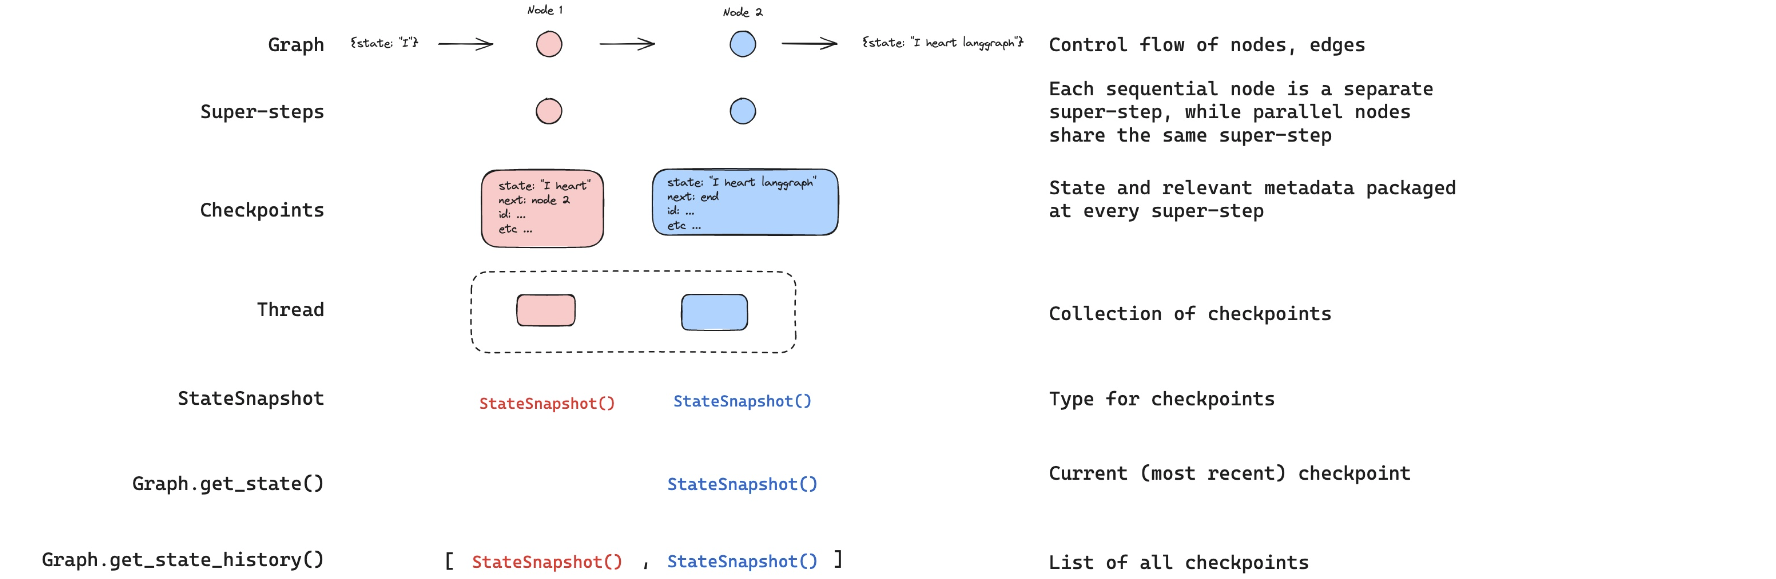

### Replaying
We can re-run our agent from any of the prior steps.

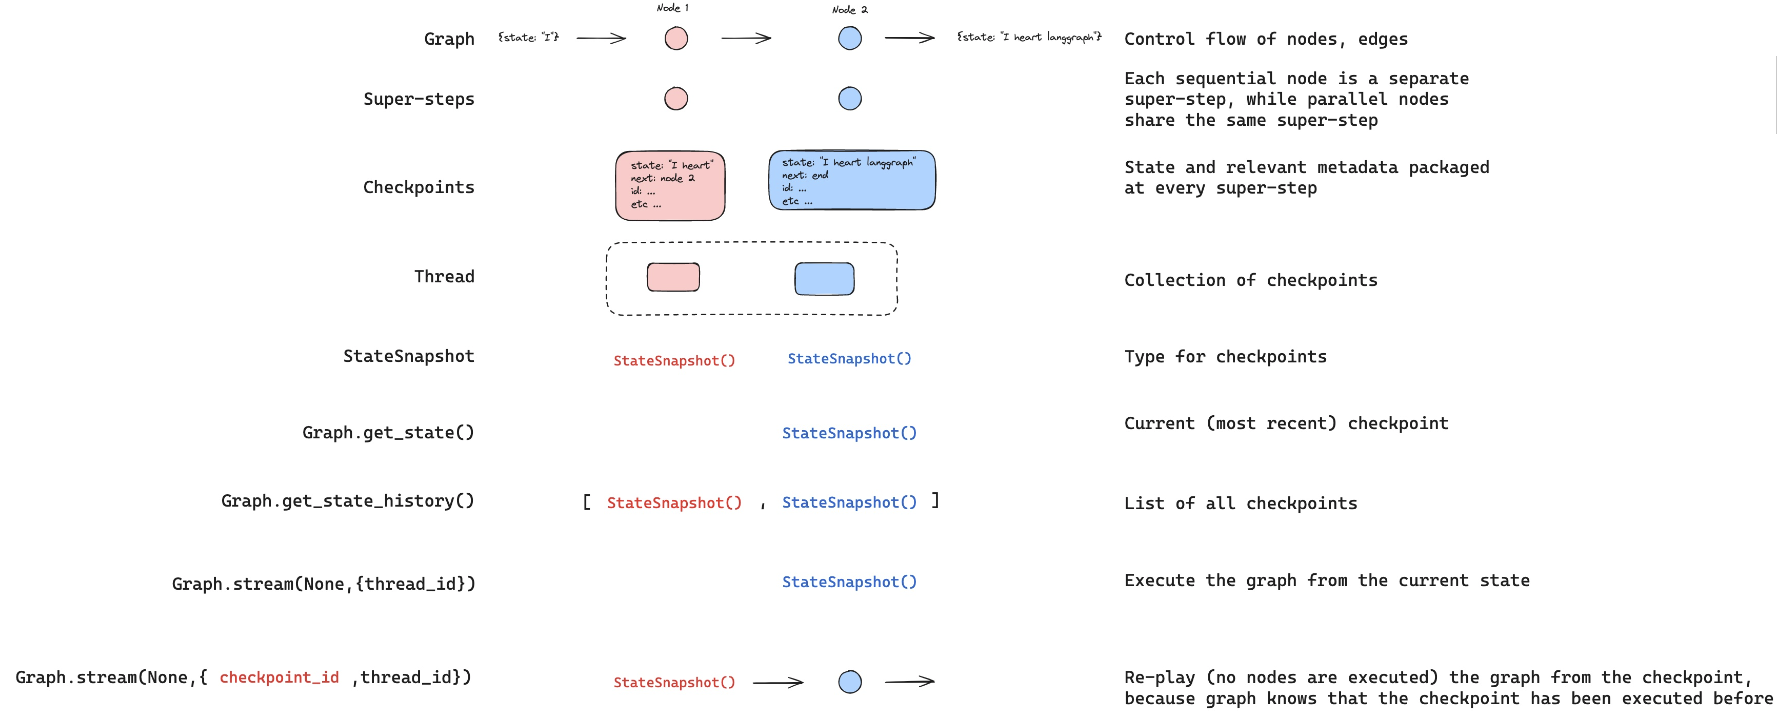

In [ ]:
to_replay= all_states[-2]

In [ ]:
to_replay

Podemos ver o próximo nó a chamar

In [ ]:
to_replay.next

Também obtemos a configuração, que nos informa o checkpoint_id, bem como o thread_id.

In [ ]:
to_replay.config

Para reproduzir a partir daqui, basta passar a configuração de volta para o agente!

O grafo sabe que este ponto de verificação já foi executado.

Ele simplesmente reproduz a partir deste ponto de verificação!

In [ ]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

### Forking

E se quisermos executar o mesmo passo, mas com uma entrada diferente?

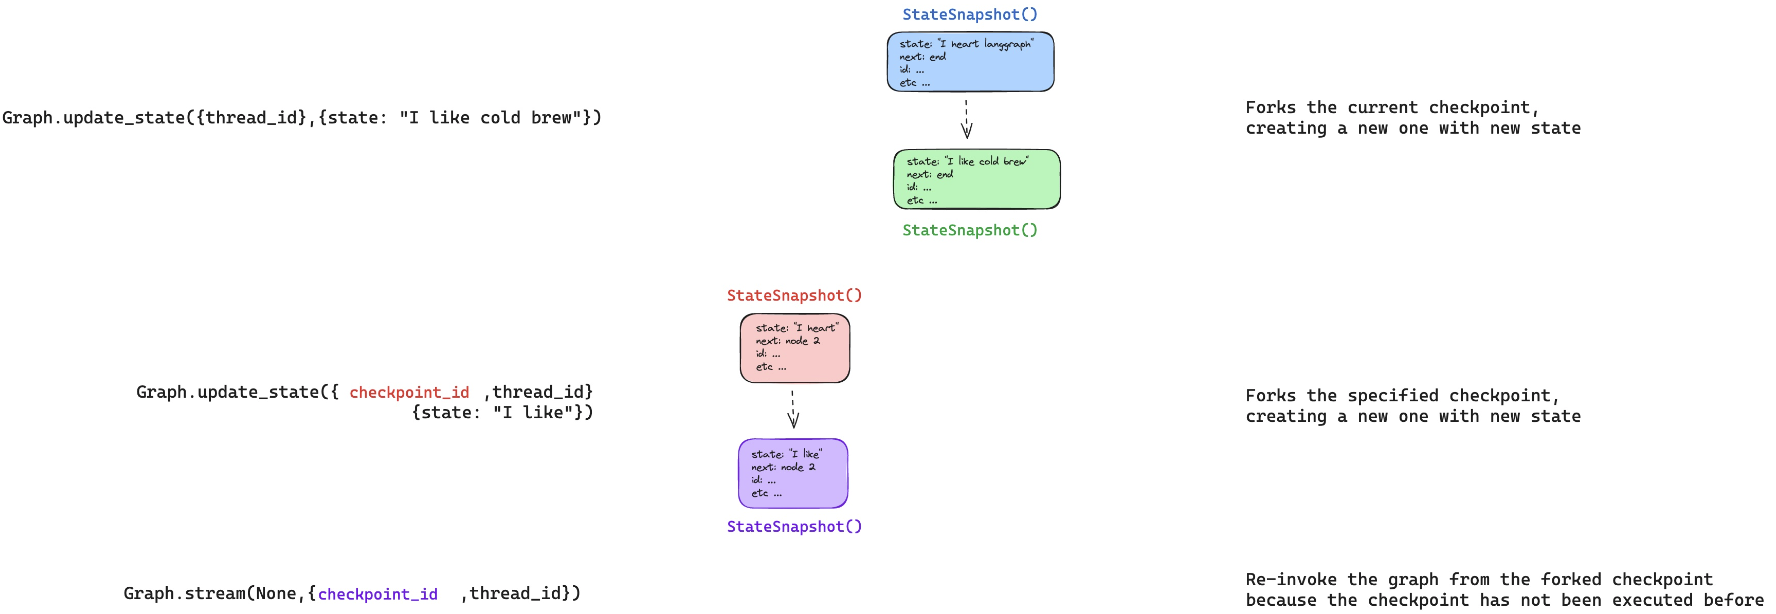

# Informação do Gemini


O Forking (Bifurcação) no LangGraph é um recurso avançado de gerenciamento de estado que permite criar uma nova thread de execução (um novo caminho ou conversa) a partir do estado salvo (checkpoint) de uma thread anterior.

É análogo ao conceito de fork (bifurcação) em sistemas de controle de versão como o Git, onde você pega um ponto específico no tempo e cria um novo ramo independente para trabalhar.

###  🧭 O Propósito do Forking
O Forking é usado principalmente para o conceito de "Viagem no Tempo" (Time Travel) e Intervenção Humana (Human-in-the-Loop) no LangGraph.

Ele permite que você:

1. Volte a um Ponto de Verificação (Checkpoint) Anterior: Se uma conversa ou processo de raciocínio deu errado, você pode carregar o estado salvo exatamente antes da decisão incorreta.

2. Crie um Novo Ramo de História: Em vez de continuar a execução a partir daquele ponto (o que seria um "Replay"), o Forking cria uma nova thread completamente separada, permitindo que a conversa original permaneça intacta.

3. Explore Alternativas: Você pode testar como o agente se sairia se o estado fosse ligeiramente diferente (ex: injetando uma nova entrada ou alterando um dado) sem afetar a execução principal.

### 🛠️ Como o Forking Funciona (Baseado no Seu Código)
O Forking utiliza o sistema de persistência (o Checkpointer, como o MemorySaver no seu código) para acessar o histórico completo da conversa.

1. Identificação do Estado: O LangGraph salva um Snapshot (instantâneo) do estado completo do grafo (todas as mensagens, o valor do summary, etc.) após cada passo de execução, criando um Checkpoint.

2. Acesso ao Checkpoint: Para fazer um fork, você precisa do ID da thread original e do ID do Checkpoint (que é o ponto exato no tempo em que você deseja voltar).

3. Criação da Nova Thread: Ao invocar o LangGraph, você fornece uma nova thread_id juntamente com a config que aponta para o estado do checkpoint antigo.

    * Isso instrui o LangGraph a carregar o estado do checkpoint anterior, mas associá-lo à nova thread_id.

    * A partir desse momento, qualquer nova execução ou alteração no estado ocorre apenas na nova thread, preservando a original.


O Forking é exatamente o processo de copiar o estado anterior e criar uma nova linha de execução totalmente separada.

### 🌳 O Forking como Criação de Ramo
Aqui está o detalhamento dos pontos-chave:

1. Cópia Completa do Estado
Quando você faz um fork a partir do Checkpoint X da Thread A, o LangGraph:

* Carrega todos os dados daquele checkpoint (o histórico de mensagens, o resumo, variáveis de estado, etc.).

* Cria uma nova Thread (Thread B) e salva a cópia dos dados como o estado inicial dessa nova thread.

2. Separação de Históricos (Sem Relação Futura)
A partir do momento do fork, as duas threads se tornam independentes e sem relação de parentesco para o futuro:

* Qualquer nova mensagem ou atualização de estado que você fizer na Thread B (o fork) será salva em novos checkpoints exclusivos para a Thread B.

* A Thread A (a original) não é afetada por nada que acontecer na Thread B. Se você retomar a Thread A, ela continuará de onde parou, ignorando todas as mudanças feitas no fork.

3. Vantagem Principal: Segurança
A principal vantagem disso é a segurança e a rastreabilidade. Você pode usar o fork para:

* Testar um caminho diferente de raciocínio.

* Corrigir manualmente um erro de estado.

* Permitir a intervenção humana.

...sem o risco de corromper o histórico principal de execução do seu agente.

# Fim da informação do Gemini

In [ ]:
to_fork= all_states[-1]
to_fork.values["messages"]

In [ ]:
to_fork.config

Vamos modificar o estado neste ponto de verificação.

Podemos simplesmente executar `update_state` com o `checkpoint_id` fornecido.

Lembre-se de como nosso reducer em `messages` funciona:

Ele irá adicionar ao estado, a menos que forneçamos um ID de mensagem.

Fornecemos o ID da mensagem para sobrescrevê-la, em vez de adicioná-la ao estado!

Portanto, para sobrescrever a mensagem, basta fornecer o ID da mensagem, que temos em `to_fork.values["messages"].id`.

In [ ]:
fork_config= graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content="Multiply 5 and 3",
                               id= to_fork.values["messages"][0].id)]}
)

In [ ]:
fork_config

In [ ]:
all_states= [s for s in graph.het_state_history(thread)]
len(all_states)

In [ ]:
all_states[0]

Isso cria um novo ponto de verificação bifurcado.

Mas os metadados — por exemplo, para onde ir em seguida — são preservados!

Podemos ver que o estado atual do nosso agente foi atualizado com a nossa bifurcação.

In [ ]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

In [ ]:
graph.get_state({'configurable': {'thread_id': '1'}})

### Time travel com langgraph API

In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

### Reproduzindo

Vamos executar nosso agente, transmitindo atualizações para o estado do grafo após cada nó ser chamado.

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

Agora, vamos ver como reproduzir a partir de um ponto de verificação específico.

Basta passar o ID do ponto de verificação.

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

Vamos transmitir com `stream_mode="values"` para ver o estado completo em cada nó enquanto reproduzimos.

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Podemos ver isso como uma transmissão contínua de atualizações de estado feitas pelos nós aos quais respondemos.

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

### Forking